In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
from itertools import product
from statsmodels.graphics.tsaplots import plot_acf

In [2]:
# Загрузка данных
data = pd.read_csv('data.csv')
data['dt'] = pd.to_datetime(data['dt'])
data.set_index('dt', inplace=True)

# Удаление дубликатов с помощью усреднения значений для одинаковых дат
data = data.groupby(data.index).mean()

# Установка частоты индекса (например, дневной)
data = data.asfreq('D')

# Заполнение пропусков
data.ffill(inplace=True)

Таким образом, данные были загружены из CSV-файла, и преобразованы в формат временного индекса.
Дубликаты были обработаны методом усреднения.
Частота была установлена на дневную, и пропуски были заполнены методом ffill

In [3]:
data['MW'].describe()

count     4017.000000
mean      3422.538379
std       2984.621873
min          4.000000
25%       1204.500000
50%       2510.000000
75%       4817.300000
max      15492.220000
Name: MW, dtype: float64

count: 4017 — Это количество дней, когда была собрана информация о мощности; 
mean: 3422.54 MW — среднее значение мощности (общая производительность ветряных мельниц за указанный период; 
std: 2984.62 MW - высокое значение стандартного отклонения показывает, что мощности значительно варьируют, что может указывать на нестабильность в производстве; 
4.00 MW — минимальное значение. Это может указывать на дни, когда производство было очень низким или ветряные установки не работали;
25% - 1204.50 MW — Указывает, что 25% дней имели мощность меньше 1204.50 MW;
50% 2510.00 MW — медиана показывает, что половина дней имела мощность меньше 2510.00 MW, и половина — больше (важный показатель для анализа распределения мощности);
75% - 4817.30 MW —  75% дней имели мощность меньше 4817.30 MW;
max: 15492.22 MW — максимальное значение, когда производство было очень высоким, возможно, из-за особенно благоприятных ветровых условий.


Выводы. Высокое стандартное отклонение (2984.62 MW) по сравнению со средним значением (3422.54 MW) указывает на то, что значение мощности сильно колеблется. Это может быть связано с сезонными и ежедневными изменениями в ветровых условиях. Минимальное значение (4.00 MW) и максимальное значение (15492.22 MW) указывают на наличие значительных выбросов. Вероятно, есть дни с аномально низким производством, а также дни с аномально высоким производством. Медиана (2510.00 MW) меньше, чем среднее (3422.54 MW), что указывает на асимметрию в распределении данных. Большой интерквартильный диапазон также подчеркивает высокую вариативность в производстве.

In [4]:
# Определение выбросов. Вычисление квартилей и IQR
Q1 = data['MW'].quantile(0.25)
Q3 = data['MW'].quantile(0.75)
IQR = Q3 - Q1

# Определение границ
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Определение выбросов
outliers = data[(data['MW'] < lower_bound) | (data['MW'] > upper_bound)]

# Вывод информации о выбросах
print("Дни с аномально низким и высоким производством:")
print(outliers)


Дни с аномально низким и высоким производством:
                  MW
dt                  
2013-06-12  10552.00
2014-12-20  10952.00
2014-12-21  10751.00
2014-12-22  10607.00
2015-02-01  10524.00
...              ...
2021-11-19  10239.69
2021-12-01  10712.41
2021-12-03  12950.33
2021-12-18  11510.26
2021-12-30  11047.50

[175 rows x 1 columns]


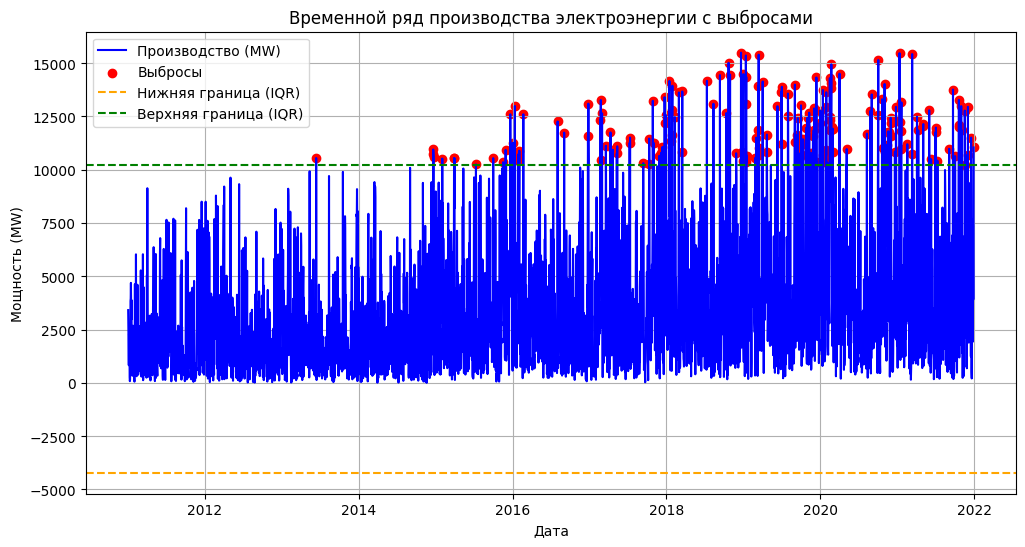

In [5]:
# Визуализация выбросов
plt.figure(figsize=(12, 6))
plt.plot(data.index, data['MW'], label='Производство (MW)', color='blue')
plt.scatter(outliers.index, outliers['MW'], color='red', label='Выбросы', marker='o')
plt.axhline(y=lower_bound, color='orange', linestyle='--', label='Нижняя граница (IQR)')
plt.axhline(y=upper_bound, color='green', linestyle='--', label='Верхняя граница (IQR)')
plt.title('Временной ряд производства электроэнергии с выбросами')
plt.xlabel('Дата')
plt.ylabel('Мощность (MW)')
plt.legend()
plt.grid()
plt.show()

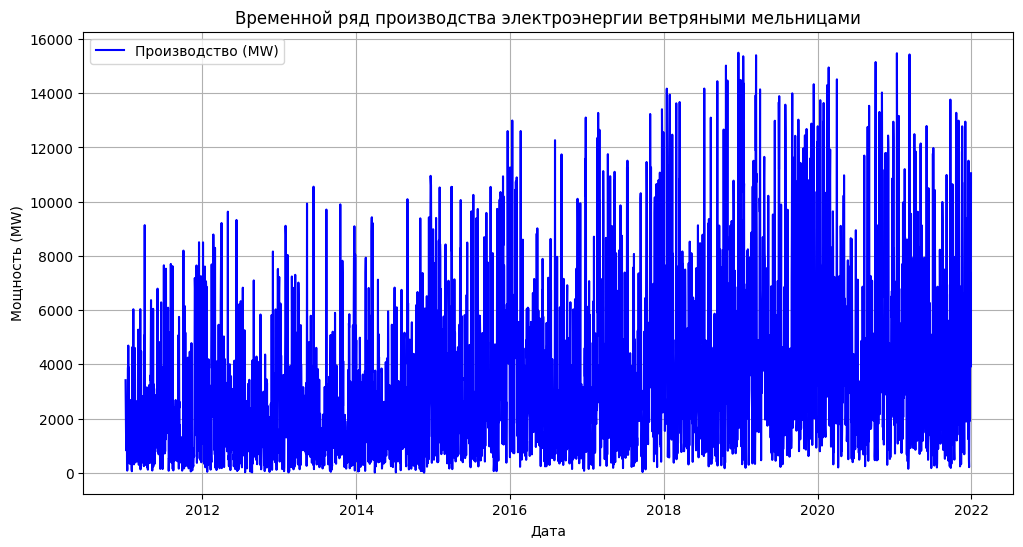

In [6]:
# визуализируем временной ряд
plt.figure(figsize=(12, 6))
plt.plot(data.index, data['MW'], label='Производство (MW)', color='blue')
plt.title('Временной ряд производства электроэнергии ветряными мельницами')
plt.xlabel('Дата')
plt.ylabel('Мощность (MW)')
plt.legend()
plt.grid()
plt.show()

Таким образом, данные содержат как долгосрочный тренд (видим нарастание мощности со временем, что по-видимому связано с ростом числа ветряных установок 
и их производительности), так и сезонные колебания (пики на каждом году, что по-видимому связано с погодными условиями: скорость ветра, 
количество солнечных дней и др). При этом в сезонности наблюдается некоторая неравномерность, так как сезонные колебания вызваны природными условиями.
Вывод: для прогнозирования производства электроэнергии ветряными мельницами в Германии необходима модель,  способная учитывать сезонные колебания 
и тренды, применимость к специфике данных и целям прогнозирования, а также зависимости между текущими и прошлыми значениями ряда Для этого хорошо 
подходит модель SARIMA (Seasonal Autoregressive Integrated Moving Average) 

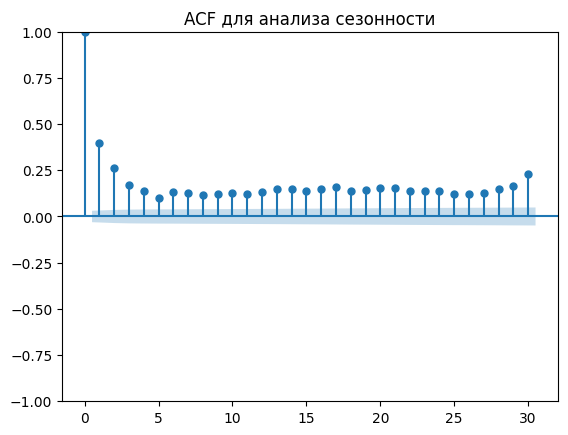

In [8]:
# Дополнительный график ACF для анализа сезонности
plot_acf(data['MW'], lags=30)  # Показать автокорреляцию до 30 лагов
plt.title('ACF для анализа сезонности')
plt.show()

In [10]:
# Данные для анализа
y = data['MW']

# Разделение данные на обучение и тест
train_size = int(len(y) * 0.8)  # 80% на обучение, 20% на тест
train, test = y[:train_size], y[train_size:]

# Определение диапазонов значений параметров
p = d = q = range(0, 3)  # 0, 1, 2
P = D = Q = range(0, 2)  # 0, 1
s = [12]  # предполагаем, что у нас годовая сезонность

# Создаем все возможные комбинации параметров
param_combinations = product(p, d, q)
seasonal_param_combinations = product(P, D, Q, s)

best_rmse = float("inf")
best_order = None
best_seasonal_order = None


Данные были разделены на обучающую (80%) и тестовую выборки(20%) для оценки качества модели
Параметры SARIMA (p, d, q) и (P, D, Q, s) были выбраны на основе перебора всех возможных комбинаций заданных диапазонов


In [11]:
# Проверяем каждую комбинацию параметров
for order in param_combinations:
    for seasonal_order in seasonal_param_combinations:
        try:
            # Обучение модели SARIMA
            model = SARIMAX(train, order=order, seasonal_order=seasonal_order)
            sarima_fit = model.fit(disp=False)
            forecast = sarima_fit.get_forecast(steps=len(test))
            forecast_values = forecast.predicted_mean

            # Вычисляем RMSE
            mse = mean_squared_error(test, forecast_values)
            rmse = np.sqrt(mse)

            # Сохраняем параметры при их улучшении
            if rmse < best_rmse:
                best_rmse = rmse
                best_order = order
                best_seasonal_order = seasonal_order

        except Exception as e:
            print(f"Ошибка при обучении модели с параметрами {order} и {seasonal_order}: {e}")

# Вывод лучших параметров и RMSE
print(f"Лучшие параметры: order={best_order}, seasonal_order={best_seasonal_order}, RMSE={best_rmse}")

Лучшие параметры: order=(0, 0, 0), seasonal_order=(0, 1, 1, 12), RMSE=3489.4174126543867


таким образом, для каждой комбинации параметров проводилась оценка модели, и RMSE для тестового набора использовался в качестве метрики производительности, найдены оптимальные параметры, которые обеспечили минимальное RMSE

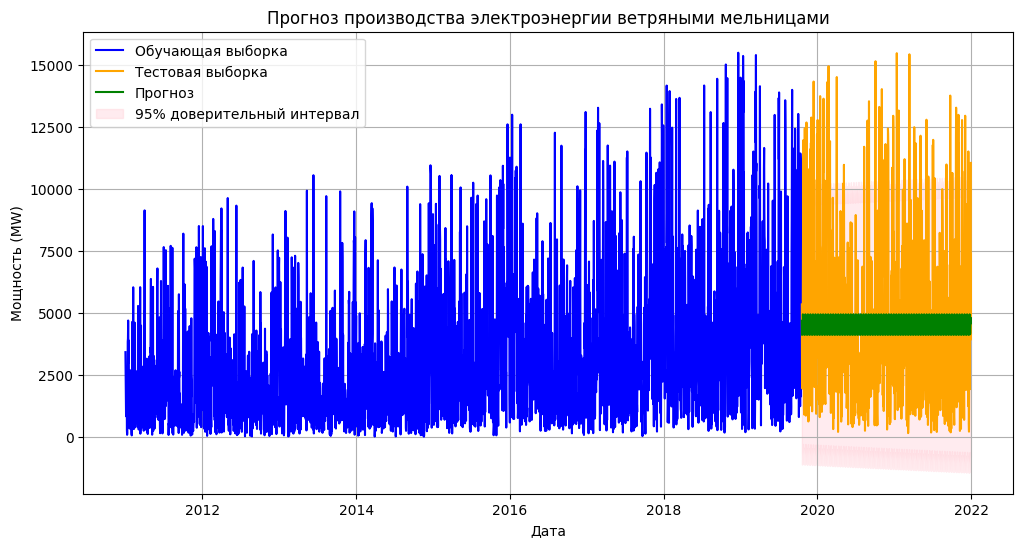

In [14]:
# Обучение модели с лучшими параметрами
final_model = SARIMAX(train, order=best_order, seasonal_order=best_seasonal_order)
final_fit = final_model.fit(disp=False)

# Прогноз на 1 год вперед
forecast = final_fit.get_forecast(steps=len(test))
forecast_index = pd.date_range(start=train.index[-1] + pd.Timedelta(days=1), 
                                  periods=len(test), freq='D')
forecast_values = forecast.predicted_mean
forecast_conf_int = forecast.conf_int()

# Визуализация результатов
plt.figure(figsize=(12, 6))
plt.plot(train.index, train, label='Обучающая выборка', color='blue')
plt.plot(test.index, test, label='Тестовая выборка', color='orange')
plt.plot(forecast_index, forecast_values, label='Прогноз', color='green')
plt.fill_between(forecast_index, 
                 forecast_conf_int.iloc[:, 0], 
                 forecast_conf_int.iloc[:, 1], 
                 color='pink', 
                 alpha=0.3, label='95% доверительный интервал')
plt.title('Прогноз производства электроэнергии ветряными мельницами')
plt.xlabel('Дата')
plt.ylabel('Мощность (MW)')
plt.legend()
plt.grid()
plt.show()


In [15]:
# Метрики качества
mse = mean_squared_error(test, forecast_values)
rmse = np.sqrt(mse)
print(f'RMSE: {rmse}')

RMSE: 3489.4174126543867


Результаты прогноза были визуализированы, включая доверительный интервал, что позволило оценить модель по сравнению с реальными наблюдаемыми значениями.
RMSE для финальной модели был вычислен и выведен для оценки точности прогноза.

Важно проанализировать остатки модели (разности между фактическими наблюдаемыми значениями и предсказанными значениями модели). Если остатки имеют автокорреляцию, это может указать на недостаточную модель, что требует дополнительных улучшений

In [19]:
# можно рассчитать как разность между фактическими значениями и предсказанными значениями
residuals = test - forecast_values

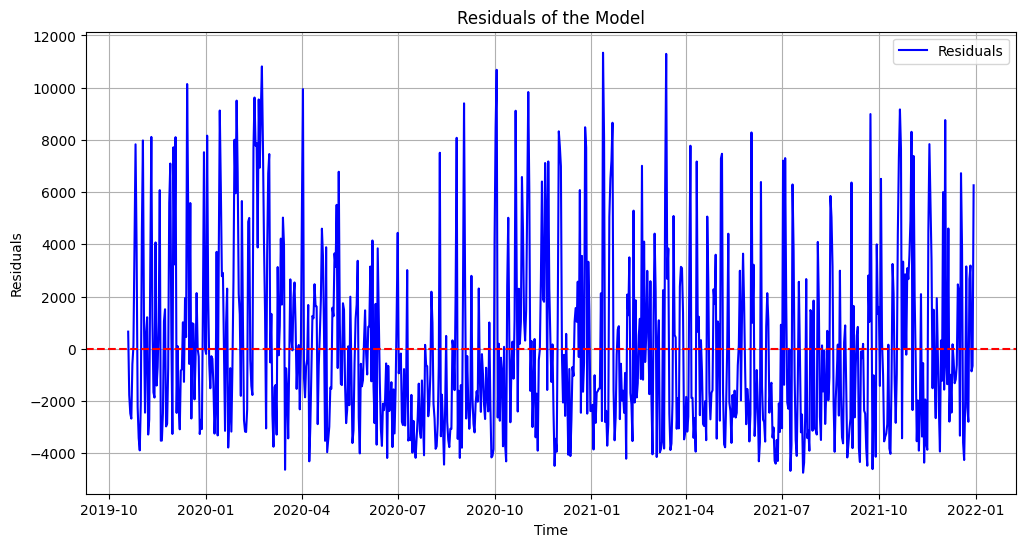

In [17]:
plt.figure(figsize=(12, 6))
plt.plot(residuals, label='Residuals', color='blue')
plt.axhline(y=0, color='red', linestyle='--')
plt.title('Residuals of the Model')
plt.xlabel('Time')
plt.ylabel('Residuals')
plt.legend()
plt.grid()
plt.show()

 На графике остатков, видно, что они ведут себя случайным образом, располагаются вокруг линии y=0 без какого-либо заметного тренда

from statsmodels.graphics.tsaplots import plot_acf
plot_acf(residuals)
plt.title('ACF of Residuals')
plt.show()

In [18]:
from statsmodels.tsa.stattools import adfuller
# Проводим тест Дики-Фуллера на стационарность остатков
result = adfuller(residuals)
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')

ADF Statistic: -19.4452918099116
p-value: 0.0


p-value меньше 0.05, можно отвергнуть нулевую гипотезу о нестационарности

Выводы.
На основе этих результатов можно сделать вывод, что остатки модели являются стационарными
Модель хорошо справляется с описанием временного ряда.
Нет необходимости в дальнейших преобразованиях для остатков 
Можно использовать модель для дальнейших прогнозов
